In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import time

In [2]:
# Generate cities
N = 1024
rng = np.random.default_rng(seed=42)
x = rng.random(N)
y = rng.random(N)

@njit
def distances(N,x,y):
  dist = np.zeros((N,N))
  for i in range(N):
    for j in range(i, N):
      dist[i,j] = np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2)
      dist[j,i] = dist[i,j]

  return dist

dist = distances(N,x,y)

@njit
def path_cost(N, path, dist):
  cost = 0
  for i in range(N):
    cost += dist[path[i-1],path[i]]

  return cost

@njit
def cost_diff(p1, p2, dist, begin, end):
  d1, d2 = 0, 0
  for i in range(begin, end+1):
    d1 += dist[p1[i-1],p1[i]]
    d2 += dist[p2[i-1],p2[i]]

    if end == N-1:
      d1 += dist[p1[end],p1[0]]
      d2 += dist[p2[end],p12[0]]
    else:
      d1 += dist[p1[end],p1[end+1]]
      d2 += dist[p2[end],p2[end+1]]

  return d1 - d2

In [3]:
@njit
def newpath(N, path, dist):
  newpath = np.zeros(N,dtype=np.int16)
  i = int(np.random.random() * N)
  j = int(np.random.random() * N)

  while i==j:
    j = int(np.random.random() * N)

  if i > j:
    begin = j
    end = i
  else:
    begin = i
    end = j

  for k in range(N):

    if k < begin or k > end:
      newpath[k] = path[k]
    else:
      newpath[k] = path[begin+end-k]

    delta = dist[newpath[begin-1],newpath[begin]] - dist[path[begin-1],path[begin]]

    if end == N-1:
      delta += dist[newpath[end],newpath[0]] - dist[path[end],path[0]]
    else:
      delta += dist[newpath[end],newpath[end+1]] - dist[path[end],path[end+1]]

  return newpath, delta

In [4]:
@njit
def mcstep(N,beta,cost,path,best_cost,best_path,dist):

  new, delta = newpath(N,path, dist)

  if delta < 0:
    cost += delta
    path = new

    if cost < best_cost:
      best_cost = cost
      best_path = path

  else:
    if np.random.random() < np.exp(-beta*delta):
      cost += delta
      path = new

  return cost,path,best_cost,best_path

In [5]:
@njit
def annealing(N, beta, x, y, dist, steps=1000000, max_suboptimal_steps=5):

  path = np.arange(N,dtype=np.int16)
  cost = path_cost(N, path, dist)

  best_cost, best_path = cost, path

  resets = int(steps / max_suboptimal_steps)
  for i in range(resets):
    cost, path = best_cost, best_path

    for j in range(max_suboptimal_steps):
      cost, path, best_cost, best_path = mcstep(
          N,
          beta,
          cost,
          path,
          best_cost,
          best_path,
          dist
      )

  return best_cost, best_path

In [6]:
# performance test
start_time = time.time()

T = 1
beta = 1/T
steps = 10**7
max_suboptimal_steps = 5
best_cost, best_path = annealing(N, beta, x, y, dist, steps, max_suboptimal_steps)

print("--- %s seconds ---" % (time.time() - start_time))

--- 38.30145311355591 seconds ---


In [7]:
def plot(cost, path, x, y, title='Best Path Found'):
  plt.plot(x[path],y[path], linestyle='dashed', color='navy')
  plt.scatter(x,y, marker='x', color='red')
  plt.title(title)
  plt.xlabel('Total Cost = ' + str(cost))
  plt.show()

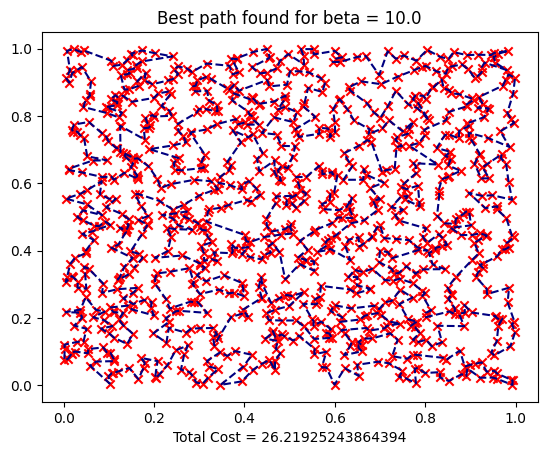

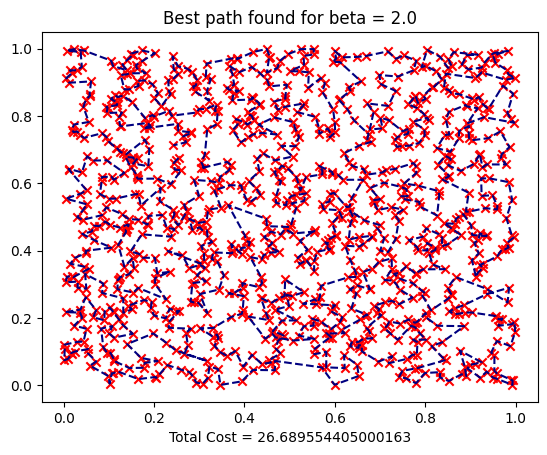

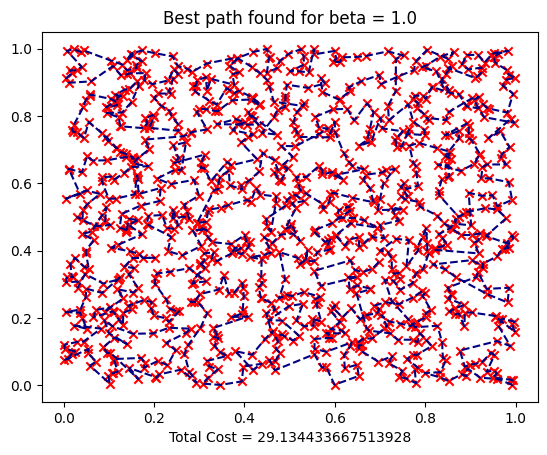

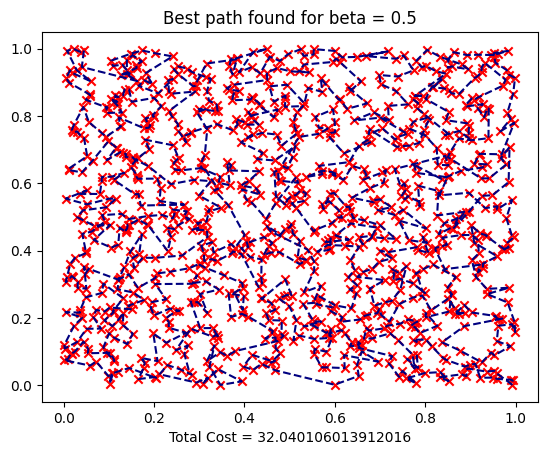

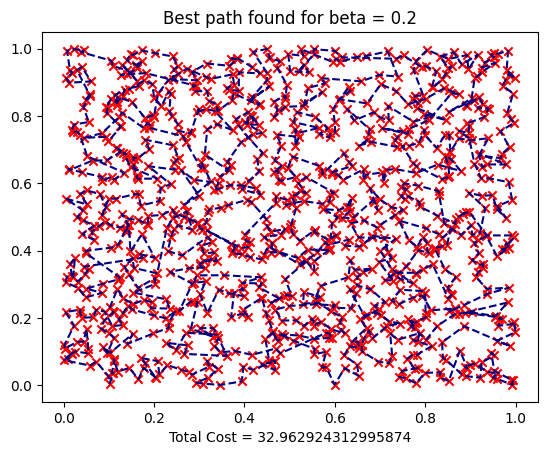

In [8]:
# variating acceptance chance of suboptimal bad path
for t in [0.1, 0.5, 1, 2, 5]:
  beta = 1/t
  steps = 10**7
  max_suboptimal_steps = 20
  best_cost, best_path = annealing(N, beta, x, y, dist, steps, max_suboptimal_steps)

  title = 'Best path found for beta = ' + str(beta)

  plot(best_cost, best_path, x, y, title=title)

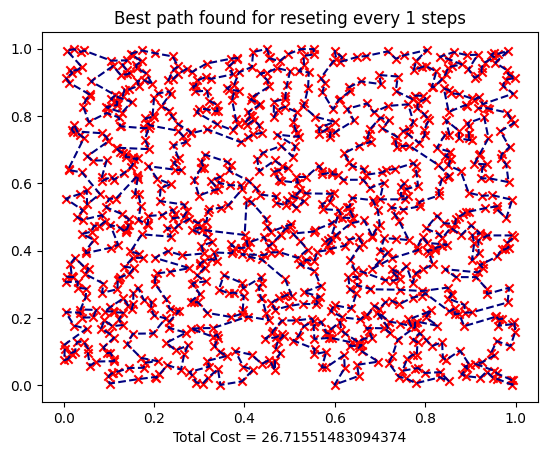

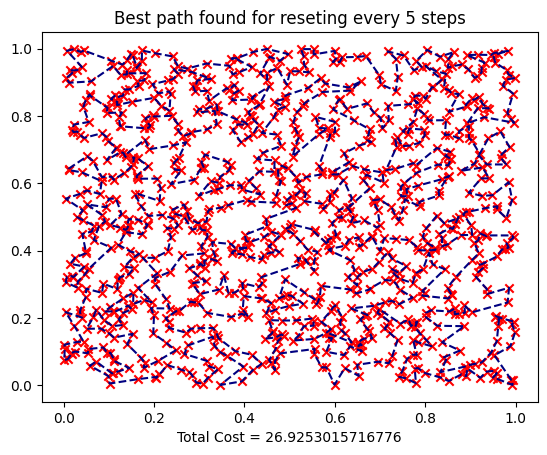

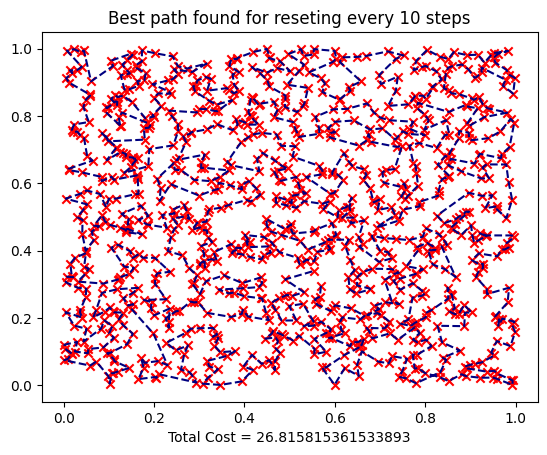

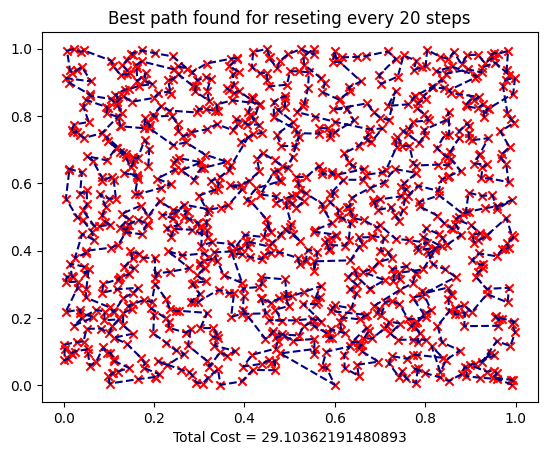

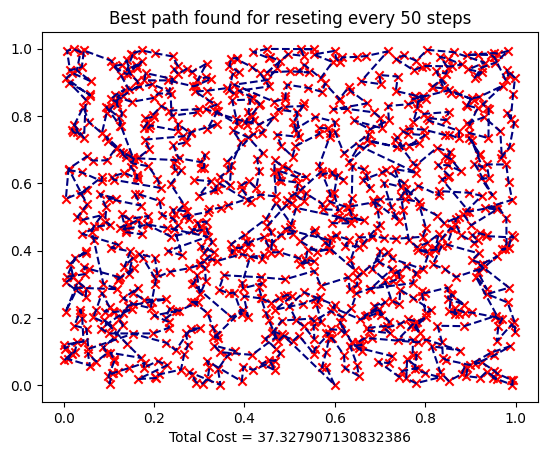

In [9]:
# variating max depth inside suboptimal path before giving up
for reset in [1, 5, 10, 20, 50]:
  t = 1
  beta = 1/t
  steps = 10**7
  max_suboptimal_steps = reset
  best_cost, best_path = annealing(N, beta, x, y, dist, steps, max_suboptimal_steps)

  title = 'Best path found for reseting every ' + str(reset) + ' steps'

  plot(best_cost, best_path, x, y, title=title)